# Fundamentals 
Models we create using deep learning or machine learning do not process text directly , we need to convert text into numbers .This process of converting text  into numbers is called **vectorization**.

one of the most easiest way to do that is **One-Hot Encoding**.

For example ,

sentence = "Do not read the next sentence."

**one-hot encoding** will be -

```
Do        [1 0 0 0 0 0 0]

not       [0 1 0 0 0 0 0]

read      [0 0 1 0 0 0 0]

the       [0 0 0 1 0 0 0]

next      [0 0 0 0 1 0 0]

sentence  [0 0 0 0 0 1 0]

.         [0 0 0 0 0 0 1]
```
**Drawbacks** -

* This will result a sparse matrix. let's say you have a corpus with 20,000 unique words and a single short text of 20 words would be represented by a matrix with 20,000 rows with a maximum of 20 non-zero matrix elements. This leaves a lot of zeroes, and can end up taking a large amount of memory for these spare representations.
* another drawback of this representation is lack of meaning representation as it treats each word as completely independent from all the others, since similarity between any two words can not be captured.

Another approach is to use **Tf-idf** i.e **Term Frequency-Inverse Document Frequency**

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. 

The **term frequency** of a word in a document : raw count of instances a word appears in a document. 

**Inverse document frequency** of the word across a set of documents. This means, how common or rare a word is in the entire document set.This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

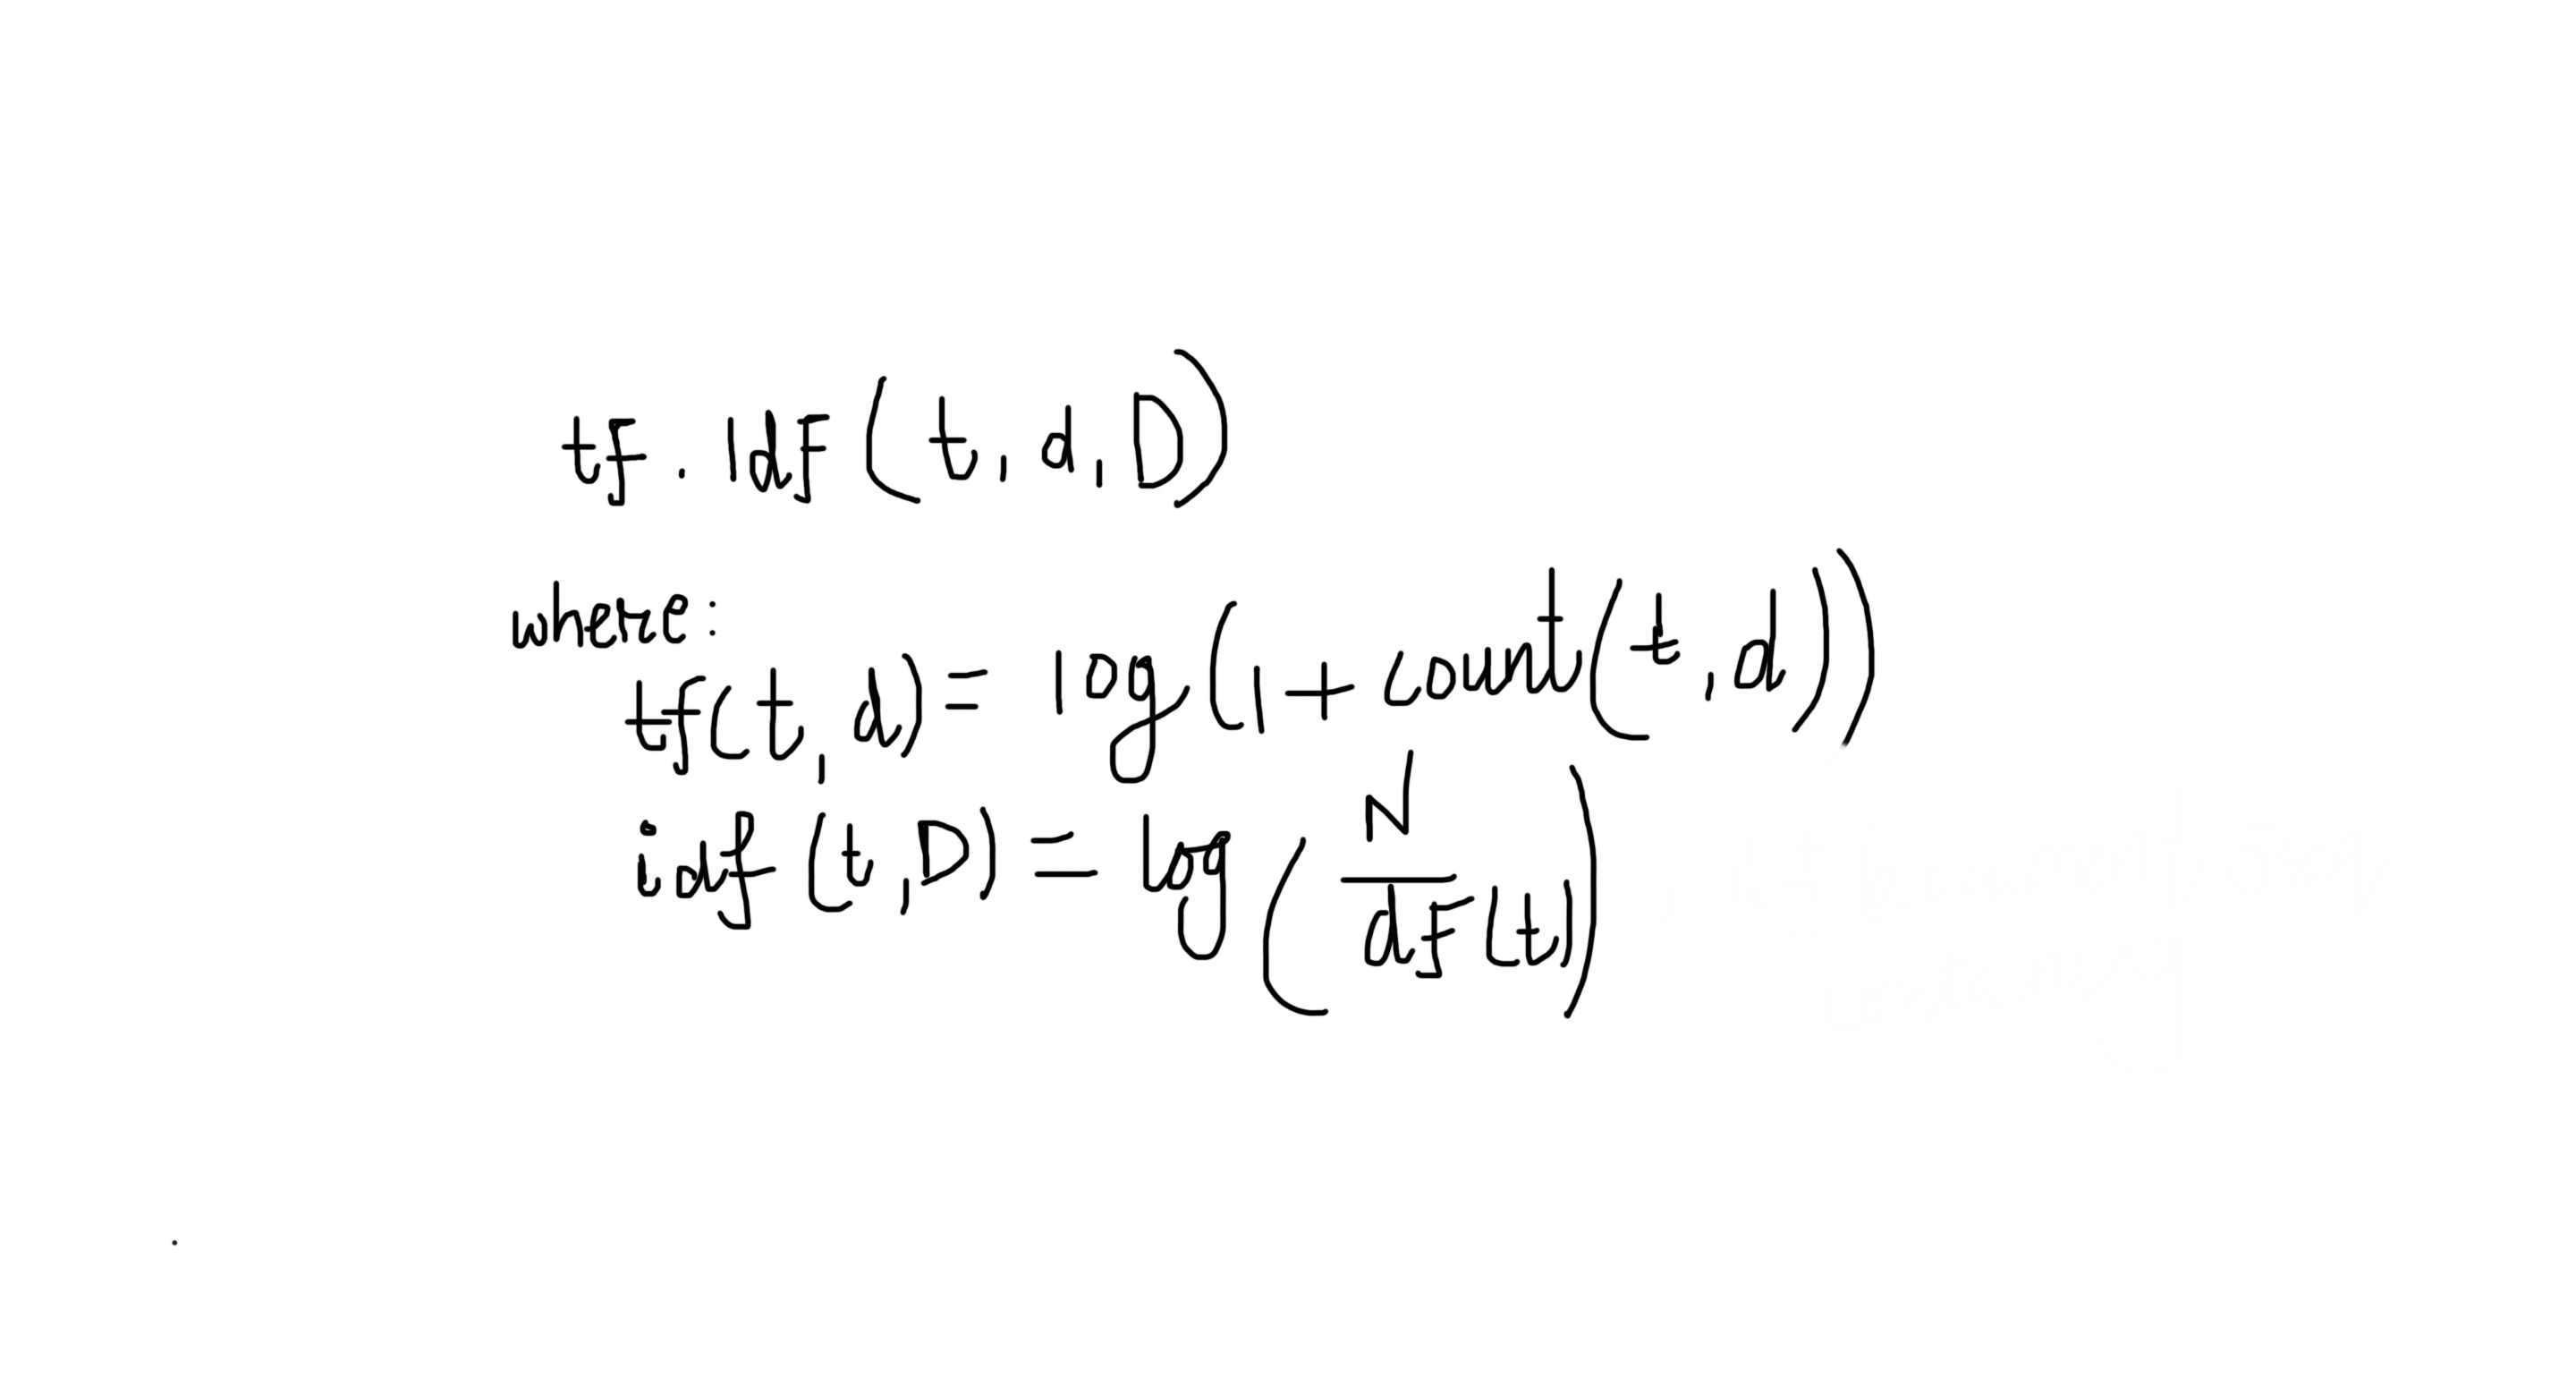

**Drawback**  of tf-idf is , it does not capture position in text and semantics,

**one-hot** and **TF-IDF** are relatively sparse embeddings, since vocabularies are usually quite large, and a word is unlikely to occur in more than a few documents in the corpus.


Another extension of one-hot encoding is BAG of WORDS model ,transforms each document to a fixed-length vector of integers.

For example - 

sentence1 = "kaggle is the world's largest data science community.Kaggle is the best platform to learn data science."
sentence2 = I love kaggle for data science . 

dictionary is 

```
["Kaggle","is","the","world's","largest","data","science","community","best","platform","to","learn","I",love","for,"."]

```

sentence1 vector form ``` [1,1,2,1,1,2,2,1,1,1,1,1,0,0,0,2] ```

sentence2 vector form ``` [1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1] ```

drawbacks - 

* no word order maintained .
* does not capture semantics 


# Word2Vec

Word2Vec Embeds text into low dimentional vectors.

There are two architectures of Word2Vec models-

1.  CBOW (Continuous bag of words model)

2.  Skip-gram


**Continuous Bag of Word model** tries to predict center word based on surrounding words.

For example , "John loves to eat apples" can be paired as (context_window,target_word) as 

```[['john','to'],'loves'],[['loves','eat],'to'],[['to','apples'],'eat']``` if size of window is 2


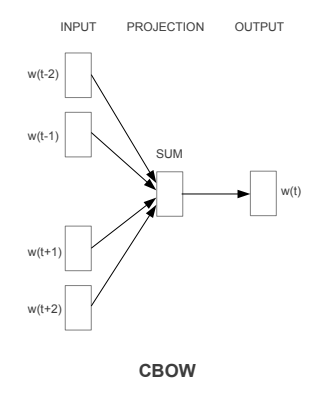

*Source: https://arxiv.org/pdf/1301.3781.pdf*



In Skip-Gram predicts the surrounding words if center word is known.

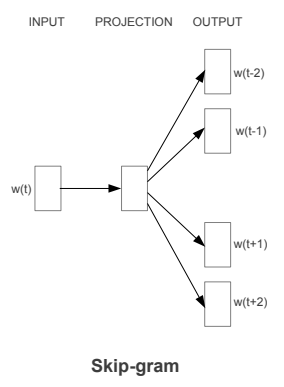

*Source: https://arxiv.org/pdf/1301.3781.pdf*



# Training your own Model using Gensim

### Import necessary librariess

In [ ]:
from gensim import utils
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import gensim.models
import re
import string
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import argparse
import gensim.downloader as api
import os
import shutil
import tensorflow as tf


### Import dataset

In [ ]:
train_data=pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1',parse_dates=['TweetAt'])

In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_data['OriginalTweet']=train_data['OriginalTweet'].apply(lambda x : clean(x))

In [ ]:
class CoronaTweetCorpus:
    def __iter__(self):
        for line in train_data['OriginalTweet']:  
            yield utils.simple_preprocess(line)

In [ ]:
sentences = CoronaTweetCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

In [ ]:
vector=model.wv['corona']

In [ ]:
vector

In [ ]:
model.wv.most_similar('corona')

In [ ]:
model.wv.most_similar('people')

In [ ]:
model.wv.most_similar('die')

In [ ]:
vector

In [ ]:
print(model.wv.most_similar(positive=['corona'], topn=5))

## saving your model

In [ ]:
word_vectors = model.wv
word_vectors.save("corona_tweets_word2vec")

In [ ]:
wv = KeyedVectors.load("corona_tweets_word2vec", mmap='r')

## Training parameters 


**min_count** -  In min count we want to ignore the words that appear less number of times , let's say if we put min count = 2 then words that appear less than 2 times will be ignored.

default value of min_count=5

**vector_size** - number of dimensions (N) of the N-dimensional space that gensim **Word2Vec** maps the words onto.

The default value of vector_size is 100

**workers** - for training parallelization, to speed up training

default value of workers=3


## Visualise word embeddings 

In [ ]:
x=model[model.wv.vocab]
words = list(model.wv.vocab)

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(x)
plt.figure(figsize=(12, 6))
plt.scatter(result[:30, 0], result[:30, 1])
for i, word in enumerate(words[:30]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Building Embedding matrix

In [ ]:
train_data

In [ ]:
# Function to get data
def get_dataset(data):
    labels=data['Sentiment'].map({'Positive':0,'Negative':1,'Neutral':2,'Extremely Positive':3,'Extremely Negative':4})
    return data['OriginalTweet'],labels

In [ ]:
tweets,labels=get_dataset(train_data)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(tweets)
text_sequences = tokenizer.texts_to_sequences(tweets)
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)
num_records = len(text_sequences)
max_seqlen = len(text_sequences[0])
print("{:d} sentences, max length: {:d}".format(num_records, max_seqlen))

In [ ]:
# creating labels
NUM_CLASSES = 5
cat_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

In [ ]:
# vocabulary
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print("vocab size: {:d}".format(vocab_size))

In [ ]:
#split into train and validation set

dataset = tf.data.Dataset.from_tensor_slices((text_sequences, cat_labels))
dataset = dataset.shuffle(10000)
val_size = num_records // 4
val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

In [ ]:
BATCH_SIZE = 128
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

### Building embedding matrix

In [ ]:
 def build_embedding_matrix(sequences, word2idx, embedding_dim,embedding_file):
    if os.path.exists(embedding_file):
        E = np.load(embedding_file)
    else:
        vocab_size = len(word2idx)
        E = np.zeros((vocab_size, embedding_dim))
        word_vectors = api.load(EMBEDDING_MODEL)
        for word, idx in word2idx.items():
            try:
                E[idx] = word_vectors.word_vec(word)
            except KeyError:   # word not in embedding
                 pass
        np.save(embedding_file, E)
    return E

In [ ]:
EMBEDDING_DIM = 300
DATA_DIR = "./"
EMBEDDING_NUMPY_FILE = os.path.join(DATA_DIR, "word2vec.npy")
EMBEDDING_MODEL = "word2vec-google-news-300"
E_word2vec = build_embedding_matrix(text_sequences, word2idx,EMBEDDING_DIM,EMBEDDING_NUMPY_FILE)
print("Embedding matrix:", E_word2vec.shape)

In [ ]:
print(E)

In [ ]:
api.info()

# Glove 

Why not word2vec?

Word2vec relies only on local information of language. That is, the semantics learnt for a given word, is only affected by the surrounding words.

**GloVe** as an unsupervised learning algorithm for obtaining vector representations for words.The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors.

**Co-occurance matrix**

Given a corpus having N words, the co-occurrence matrix X will be a N x N matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. 

For example,

I like deep learning.
I like NLP.
I enjoy learning.

```
         I  like enjoy deep learning NLP 
I        [0  2    1     0     0]
like     [2  0    0     1     0]
enjoy    [1  0    0     0     1]
deep     [0  1    0     0     1]
learning [0  0    1     1     0]
NLP      [0  1    0     0     0]

```


The GloVe process factorizes this co-occurrence matrix into a pair of (word, feature) and (feature, context) matrices. The process is known as Matrix Factorization and is done using Stochastic Gradient Descent (SGD)


R = P * Q

The SGD process will start with P and Q composed of random values and attempt to reconstruct the matrix R' by multiplying them. The difference between the matrices R and R' represents the loss, and is usually computed as the mean-squared error between the two matrices. The loss dictates how much the values of P and Q need
to change for R' to move closer to R to minimize the reconstruction loss. This process is repeated multiple times until the loss is within some acceptable threshold. At that point the (word, feature) matrix P is the GloVe embedding.
The GloVe process is much more resource intensive than Word2Vec. This is because Word2Vec learns the embedding by training over batches of word vectors, while GloVe factorizes the entire co-occurrence matrix in one shot.


In [ ]:
EMBEDDING_DIM = 300
DATA_DIR = "./"
EMBEDDING_NUMPY_FILE = os.path.join(DATA_DIR, "glove.npy")
EMBEDDING_MODEL = "glove-wiki-gigaword-300"
E_glove = build_embedding_matrix(text_sequences, word2idx,EMBEDDING_DIM,EMBEDDING_NUMPY_FILE)
print("Embedding matrix:", E_glove.shape)

In [ ]:
E_glove